# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame
#asl.df['nose-x']
#asl.df[1:11]
#asl.df.ix[98,1]
#asl.df['left-x'] [1:10]

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame


left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
#asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary
asl.df['grnd-ry'][:11]

video  frame
98     0        113
       1        113
       2        113
       3        113
       4        113
       5        113
       6        113
       7        113
       8        113
       9        113
       10       113
Name: grnd-ry, dtype: int64

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,3][v] for v in features_ground]
#[asl.df.ix[81,19][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
#print([asl.df.ix[1,8][v] for v in features_ground])
#print(training._data['JOHN'])
#print(training._hmm_data['FISH'])
#print(training._hmm_data )
#print(training.num_items)
#print(len(training.words))
#print("Training words: {}".format(training.words))

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
#training.get_word_Xlengths('VEGETABLE')

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


In [9]:
df_min=asl.df.groupby('speaker').min()
df_max=asl.df.groupby('speaker').max()
df_max
 

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,290,251,231,251,201,84,189,69,190,119
woman-1,235,191,209,179,174,70,124,46,137,70
woman-2,236,219,209,214,182,82,157,51,162,68


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [10]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [11]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [12]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
asl.df['norm-rx']= (asl.df['right-x']-asl.df['speaker'].map(df_means['right-x']))/ asl.df['speaker'].map(df_std['right-x'])
asl.df['norm-ry']= (asl.df['right-y']-asl.df['speaker'].map(df_means['right-y']))/ asl.df['speaker'].map(df_std['right-y'])
asl.df['norm-lx']= (asl.df['left-x']-asl.df['speaker'].map(df_means['left-x']))/ asl.df['speaker'].map(df_std['left-x'])
asl.df['norm-ly']= (asl.df['left-y']-asl.df['speaker'].map(df_means['left-y']))/ asl.df['speaker'].map(df_std['left-y'])

#asl.df.head()

In [13]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
import numpy as np
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
asl.df['polar-rr'] = np.sqrt((asl.df['grnd-rx'])**2+(asl.df['grnd-ry'])**2)
asl.df['polar-lr'] = np.sqrt((asl.df['grnd-lx'])**2+(asl.df['grnd-ly'])**2) 
asl.df['polar-rtheta'] = np.arctan(asl.df['grnd-rx']/asl.df['grnd-ry'])
asl.df['polar-ltheta'] = np.arctan(asl.df['grnd-lx']/asl.df['grnd-ly'])
#asl.df.ix[98,1]

In [14]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)  
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)  
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0) 
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0) 


#asl.df.ix[98]


In [15]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
#distanze diagonali?
# TODO define a list named 'features_custom' for building the training set
 
#Rescaling Raw Data
df_min=asl.df.groupby('speaker').min()
df_max=asl.df.groupby('speaker').max()

#feature_custom=  ['resc-rx','resc-ry','resc-lx','resc-ly']
asl.df['resc-rx']= (asl.df['right-x']-asl.df['speaker'].map(df_min['right-x']))/ (asl.df['speaker'].map(df_max['right-x'])-asl.df['speaker'].map(df_min['right-x']))
asl.df['resc-ry']= (asl.df['right-y']-asl.df['speaker'].map(df_min['right-y']))/ (asl.df['speaker'].map(df_max['right-y']) - asl.df['speaker'].map(df_min['right-y']))
asl.df['resc-lx']= (asl.df['left-x']-asl.df['speaker'].map(df_min['left-x']))/ (asl.df['speaker'].map(df_max['left-x']) - asl.df['speaker'].map(df_min['left-x']))
asl.df['resc-ly']= (asl.df['left-y']-asl.df['speaker'].map(df_min['left-y']))/(asl.df['speaker'].map(df_max['left-y']) - asl.df['speaker'].map(df_min['left-y']))
#CV  0.57
#BIC 0.58
#DIC  

#Normalization Feature Ground

#feature_custom=  ['norm-grnd-rx','norm-grnd-ry','norm-grnd-lx','norm-grnd-ly']
asl.df['norm-grnd-rx']= (asl.df['grnd-rx']-asl.df['speaker'].map(df_means['grnd-rx']))/ asl.df['speaker'].map(df_std['grnd-rx'])
asl.df['norm-grnd-ry']= (asl.df['grnd-ry']-asl.df['speaker'].map(df_means['grnd-ry']))/ asl.df['speaker'].map(df_std['grnd-ry'])
asl.df['norm-grnd-lx']= (asl.df['grnd-lx']-asl.df['speaker'].map(df_means['grnd-lx']))/ asl.df['speaker'].map(df_std['grnd-lx'])
asl.df['norm-grnd-ly']= (asl.df['grnd-ly']-asl.df['speaker'].map(df_means['grnd-ly']))/ asl.df['speaker'].map(df_std['grnd-ly'])
#CV  0.578
#BIC 0.533
#DIC  

#Rescaling Feature Ground
df_min=asl.df.groupby('speaker').min()
df_max=asl.df.groupby('speaker').max()

#feature_custom=  ['resc-grnd-rx','resc-grnd-ry','resc-grnd-lx','resc-grnd-ly']
asl.df['resc-grnd-rx']= (asl.df['grnd-rx']-asl.df['speaker'].map(df_min['grnd-rx']))/ (asl.df['speaker'].map(df_max['grnd-rx'])-asl.df['speaker'].map(df_min['grnd-rx']))
asl.df['resc-grnd-ry']= (asl.df['grnd-ry']-asl.df['speaker'].map(df_min['grnd-ry']))/ (asl.df['speaker'].map(df_max['grnd-ry']) - asl.df['speaker'].map(df_min['grnd-ry']))
asl.df['resc-grnd-lx']= (asl.df['grnd-lx']-asl.df['speaker'].map(df_min['grnd-lx']))/ (asl.df['speaker'].map(df_max['grnd-lx']) - asl.df['speaker'].map(df_min['grnd-lx']))
asl.df['resc-grnd-ly']= (asl.df['grnd-ly']-asl.df['speaker'].map(df_min['grnd-ly']))/(asl.df['speaker'].map(df_max['grnd-ly']) - asl.df['speaker'].map(df_min['grnd-ly']))
#CV  0.6123
#BIC 0.567
#DIC  

#Normalizing Feature Polar
df_means = asl.df.groupby('speaker').mean()
df_std =asl.df.groupby('speaker').std()

#feature_custom=  ['norm-polar-rr','norm-polar-rtheta','norm-polar-lr','norm-polar-ltheta']
asl.df['norm-polar-rr']= (asl.df['polar-rr']-asl.df['speaker'].map(df_means['polar-rr']))/ asl.df['speaker'].map(df_std['polar-rr'])
asl.df['norm-polar-rtheta']= (asl.df['polar-rtheta']-asl.df['speaker'].map(df_means['polar-rtheta']))/ asl.df['speaker'].map(df_std['polar-rtheta'])
asl.df['norm-polar-lr']= (asl.df['polar-lr']-asl.df['speaker'].map(df_means['polar-lr']))/ asl.df['speaker'].map(df_std['polar-lr'])
asl.df['norm-polar-ltheta']= (asl.df['polar-ltheta']-asl.df['speaker'].map(df_means['polar-ltheta']))/ asl.df['speaker'].map(df_std['polar-ltheta'])
#CV  0.657
#BIC 0.573
#DIC  

#Rescaling Feature Polar
df_min = asl.df.groupby('speaker').min()
df_max =asl.df.groupby('speaker').max()

#feature_custom=  ['resc-polar-rr','resc-polar-rtheta','resc-polar-lr','resc-polar-ltheta']

asl.df['resc-polar-rr']= (asl.df['polar-rr']-asl.df['speaker'].map(df_min['polar-rr']))/ (asl.df['speaker'].map(df_max['polar-rr'])-asl.df['speaker'].map(df_min['polar-rr']))
asl.df['resc-polar-rtheta']= (asl.df['polar-rtheta']-asl.df['speaker'].map(df_min['polar-rtheta']))/ (asl.df['speaker'].map(df_max['polar-rtheta']) - asl.df['speaker'].map(df_min['polar-rtheta']))
asl.df['resc-polar-lr']= (asl.df['polar-lr']-asl.df['speaker'].map(df_min['polar-lr']))/ (asl.df['speaker'].map(df_max['polar-lr']) - asl.df['speaker'].map(df_min['polar-lr']))
asl.df['resc-polar-ltheta']= (asl.df['polar-ltheta']-asl.df['speaker'].map(df_min['polar-ltheta']))/(asl.df['speaker'].map(df_max['polar-ltheta']) - asl.df['speaker'].map(df_min['polar-ltheta']))
#CV  0.578
#BIC 0.589
#DIC  
 
#Feature Delta, with Nose position

#feature_custom = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly','delta-nose-x','delta-nose-y']
 
asl.df['delta-nose-x'] = asl.df['nose-x'].diff().fillna(0)  
asl.df['delta-nose-y'] = asl.df['nose-y'].diff().fillna(0)  
#CV  0.7977
#BIC 0.6910
#DIC  


#Feature Delta - Normalized
df_means = asl.df.groupby('speaker').mean()
df_std =asl.df.groupby('speaker').std()

#feature_custom=  ['norm-delta-rx','norm-delta-ry','norm-delta-lx','norm-delta-ly' ]
asl.df['norm-delta-rx']= (asl.df['delta-rx']-asl.df['speaker'].map(df_means['delta-rx']))/ asl.df['speaker'].map(df_std['delta-rx'])
asl.df['norm-delta-ry']= (asl.df['delta-ry']-asl.df['speaker'].map(df_means['delta-ry']))/ asl.df['speaker'].map(df_std['delta-ry'])
asl.df['norm-delta-lx']= (asl.df['delta-lx']-asl.df['speaker'].map(df_means['delta-lx']))/ asl.df['speaker'].map(df_std['delta-lx'])
asl.df['norm-delta-ly']= (asl.df['delta-ly']-asl.df['speaker'].map(df_means['delta-ly']))/ asl.df['speaker'].map(df_std['delta-ly'])
#CV   0.6011 
#BIC  0.578
#DIC   


#Mixture of best performing set of features

#feature_custom=  ['resc-rx','resc-ry','resc-lx','resc-ly','resc-polar-rr','resc-polar-rtheta','resc-polar-lr','resc-polar-ltheta']
#CV 0.522
#BIC 0.517
#DIC  


#Mixture of best performing set of features extended
#Best for now!
feature_custom=  ['resc-rx','resc-ry','resc-lx','resc-ly','resc-polar-rr','resc-polar-rtheta','resc-polar-lr','resc-polar-ltheta','norm-delta-rx','norm-delta-ry','norm-delta-lx','norm-delta-ly']
#DIC  0.52  ---> WER =   (by normalizing recognized word)
#BIC 0.4550 ---> WER = 0.42696629213483145 once translated GO1 to GO etc. (by normalizing recognized word)
#CV 0.505   ---> WER = 0.48314606741573035 (by normalizing recognized word)

 
asl.df.head()

 


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly      ...        resc-polar-rr  \
video frame                                 ...                        
98    0          113        9      119      ...             0.894177   
      1          113        9      119      ...             0.894177   
      2          113        9      119      ...             0.894177   
      3          113        9      119      ...             0.894177   
      4          113        9      119      ...             0.894177   

             resc-polar-rtheta  resc-polar-lr  resc-polar-ltheta  \
video frame                                                        
98    0               0.530262       0.814022           0.072769   
      1               0.530262       0.814022           0.072769   
      2               0.530262       0.814022           0.072769   
      3               0.530262       0.814022           0.072769   
      4               0.530262       0.814022           0.072769   

             delta-nose-x  delta-nose-y  norm-delta-rx  norm-delta-ry  \
video frame                                                             
98    0               0.0           0.0      -0.010823       0.043234   
      1               0.0           0.0      -0.010823       0.043234   
      2               0.0           0.0      -0.010823       0.043234   
      3               0.0           0.0      -0.010823       0.043234   
      4               0.0           0.0      -0.010823       0.043234   

             norm-delta-lx  norm-delta-ly  
video frame                                
98    0           0.058404       0.047154  
      1           0.058404       0.047154  
      2           0.058404       0.047154  
      3           0.058404       0.047154  
      4           0.058404       0.047154  

[5 rows x 50 columns]

# **Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** 
The approach taken to identify a set of features to use for the sign recognition task was mainly based on 2 considerations:
1) how useful/relevant they empirically proved to be when used during the training/test phase
2) when considering combined feature sets, I have tried to avoid redundant/uninteresting information

The features sets considered were:
1) rescaling raw data
2) normalizing feature ground
3) rescaling feature ground
4) normalizing feature polar
5) rescaling feature polar
6) extending the feature delta set to include nose-x, nose-y 
7) normalizing feature delta

The combinations of features sets were:
1) rescaled raw variables and rescaled polar variables
2) the ones in point 1 plus normalized delta

The final set of features chosen yielded an estimated WER of ca 45% when using BIC, 50% when using CV and 52% with DIC. 
These values improved further when a change in the recognizer was introduced, such that different versions of the same sign were translated to the same sign (ex. GO1 --> GO, GO2 -->GO, FUTURE1--> FUTURE, BUY1 --> BUY, etc.). 
In this case, the estimated WER is ca 41% for BIC, 48% for CV and 49% for DIC. 


<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [16]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3) 
    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
 
                        
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.012s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [17]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'VEGETABLE'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for VEGETABLE is 3
logL = -771.3555250052293


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [18]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for VEGETABLE is 3
hidden state #0
mean =  [ -17.6969697    33.63636364  -12.42424242  125.93939394]
variance =  [ 5.96908173  8.71655647  2.85062443  1.02693297]

hidden state #1
mean =  [ -15.26923077   42.46153846   32.07692308  177.53846154]
variance =  [ 11.73559172  19.40275148   9.53292899  21.55659763]

hidden state #2
mean =  [ -21.95454545   39.90909091   23.27272727  132.13636364]
variance =  [  4.04384298  24.35582645   5.47152893   3.30004132]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [19]:
my_testword = 'BREAK-DOWN'
model, logL = train_a_word(my_testword, 4, features_norm) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for BREAK-DOWN is 4
hidden state #0
mean =  [ 0.07036931  0.54290679  0.48501685 -1.00478236]
variance =  [ 0.0241515   0.08629316  0.03319973  0.10836317]

hidden state #1
mean =  [-0.11479472 -0.57889578  0.93334019 -2.56466869]
variance =  [ 0.07256668  0.02233582  0.03313764  0.06454383]

hidden state #2
mean =  [-0.35836564 -0.6700644   1.44361851 -2.50436424]
variance =  [ 0.0189412   0.01592116  0.05276961  0.00933171]

hidden state #3
mean =  [ 0.24826133 -0.06153893  0.78349142 -1.74340738]
variance =  [ 0.0226706   0.02157037  0.03735826  0.04581574]

logL = 57.05917382256558


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [20]:
%matplotlib inline

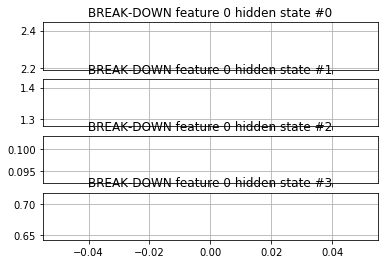

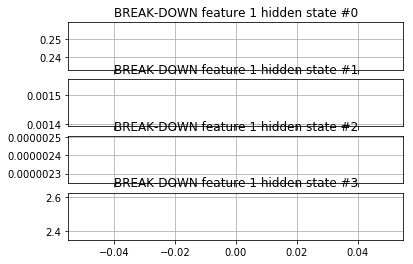

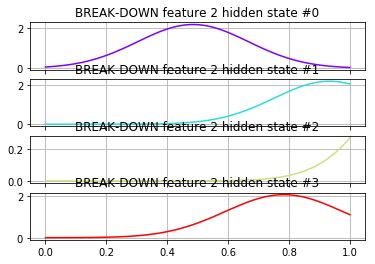

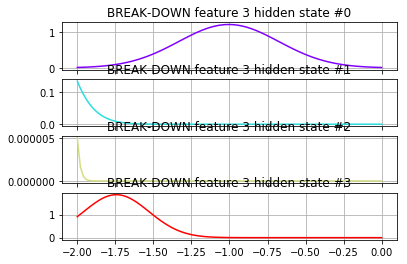

In [21]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [22]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'FISH' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for FISH is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [23]:
from sklearn.model_selection import KFold
 

training = asl.build_training(feature_custom) # Experiment here with different feature sets
word = 'BREAK-DOWN' # Experiment here with different words
word_sequences = training.get_word_sequences(word)

split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3] Test fold indices:[0 1]
Train fold indices:[0 1 3] Test fold indices:[2]
Train fold indices:[0 1 2] Test fold indices:[3]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [24]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [25]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [41]:
#rima tests
words_to_train=['FISH']
training = asl.build_training(features_ground)
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()


In [27]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV
words_to_train= ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
training = asl.build_training(feature_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    
    start = timeit.default_timer()
    
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))


Training complete for FISH with 2 states with time 0.01219133232821296 seconds
Training complete for BOOK with 9 states with time 3.888001196176314 seconds
Training complete for VEGETABLE with 15 states with time 1.3037793205733639 seconds
Training complete for FUTURE with 6 states with time 2.8466394732897387 seconds
Training complete for JOHN with 14 states with time 53.01647876352825 seconds


In [60]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC
words_to_train= ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
training = asl.build_training(feature_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 6 states with time 2.840475464981864 seconds
Training complete for BOOK with 12 states with time 8.499720778919254 seconds
Training complete for VEGETABLE with 2 states with time 4.288781806943916 seconds
Training complete for FUTURE with 6 states with time 7.954542657013917 seconds
Training failed for JOHN


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** 
The HMMs models were trained on 5 words using feature_custom.
The domain of "number of occurences" was well represented by the 5 words provided, with FISH being one of the less frequent and John being the most available sign for training (ca 16% of the times). Also the domain of "number of distinct" speakers for sign is well represented, ranging from 1 only for FISH to 3 for JOHN and BOOK.

**SIGN** **Occurences in the training dataset** **Number of distinct speakers**
FISH                   2                                1
BOOK                   18                               3 
VEGETABLE              6                                2
FUTURE                 15                               2
JOHN                   113                              3 

Please refer to the training summary below for an overview of the best number of states between 2 and 15 according to BIC,DIC and CV model selection methods.
*******************************************************************************
BIC
Training complete for FISH with 6 states with time 0.3079824062260741 seconds
Training complete for VEGETABLE with 4 states with time 0.7154030849133051 seconds
Training complete for FUTURE with 9 states with time 1.6199698161590277 seconds
Training complete for BOOK with 12 states with time 2.605835441810086 seconds
Training complete for JOHN with 15 states with time 36.61999926749195 seconds

DIC
Training complete for FISH with 4 states with time 2.0472271003618516 seconds
Training complete for VEGETABLE with 2 states with time 2.5166164043166646 seconds
Training complete for FUTURE with 14 states with time 3.4414029859872244 seconds
Training complete for BOOK with 12 states with time 4.25278985303521 seconds
Training complete for JOHN with 15 states with time 38.23632164933406 seconds

CV
Training complete for FISH with 2 states with time 0.014864616376144113 seconds
Training complete for VEGETABLE with 15 states with time 1.3071215211084564 seconds
Training complete for FUTURE with 6 states with time 3.5878002761628522 seconds
Training complete for BOOK with 9 states with time 3.996882689677477 seconds
Training complete for JOHN with 14 states with time 48.812004212295506 seconds
********************************************************************************
We can first notice that the time spent in training increases with the number of examples for each word across all methods.

In terms of time required for training, BIC performs better than the other 2 methods. Compared to CV, it does not require a rotating split of the data set in training/test sets nor a training and testing phase. Compared to DIC, it does not require to test for the the probabilities of generating competing words. 

In terms of model complexity, CV seems to find less complex models than the other two when there is enough training data.
For example, the model built for FUTURE, BOOK and JOHN are simpler than the ones identified by BIC and DIC. However, when there is fewer data (ex. VEGETABLE), CV seems to try too hard to explain the training data (15 states vs. 4 or 2 states in BIC and DIC). This was avoided with FISH,where we have only 2 examples in the training set. My program returns a model with 2 states when the number of examples is less than 3. This was done to avoid overfitting, though I am unsure about the expected behaviour in this occasion.
BIC is meant to find the simplest model that best explain the data by applying a penalty to model complexity. The penalty is larger when the number of data points is greater than 7.4 (slides http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf).This may explain why with the words FUTURE, BOOK or JOHN the models found by BIC are either smaller or equal to the ones returned by DIC.  



In [46]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC
words_to_train= ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
training = asl.build_training(feature_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    
    start = timeit.default_timer()
   
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.41242331803755405 seconds
Training complete for BOOK with 6 states with time 2.6233430333868455 seconds
Training complete for VEGETABLE with 4 states with time 0.6550613399062968 seconds
Training complete for FUTURE with 6 states with time 1.4984219005987143 seconds
Training complete for JOHN with 15 states with time 36.32213352846725 seconds


<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [59]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 52.483s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [31]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [32]:
test_set = asl.build_test(features_ground)

#print(test_set.sentences_index)
print(test_set.wordlist)
#print(test_set.df.ix[0])
#print(test_set._hmm_data[0])
#print(test_set.num_items)
#print("Number of test set items: {}".format(test_set.num_items))
#print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

['JOHN', 'WRITE', 'HOMEWORK', 'JOHN', 'CAN', 'GO', 'CAN', 'JOHN', 'CAN', 'GO', 'CAN', 'JOHN', 'FISH', 'WONT', 'EAT', 'BUT', 'CAN', 'EAT', 'CHICKEN', 'JOHN', 'LIKE', 'IX', 'IX', 'IX', 'JOHN', 'LIKE', 'IX', 'IX', 'IX', 'JOHN', 'LIKE', 'IX', 'IX', 'IX', 'MARY', 'VEGETABLE', 'KNOW', 'IX', 'LIKE', 'CORN1', 'JOHN', 'IX', 'THINK', 'MARY', 'LOVE', 'JOHN', 'MUST', 'BUY', 'HOUSE', 'FUTURE', 'JOHN', 'BUY', 'CAR', 'SHOULD', 'JOHN', 'SHOULD', 'NOT', 'BUY', 'HOUSE', 'JOHN', 'DECIDE', 'VISIT', 'MARY', 'JOHN', 'FUTURE', 'NOT', 'BUY', 'HOUSE', 'JOHN', 'WILL', 'VISIT', 'MARY', 'JOHN', 'NOT', 'VISIT', 'MARY', 'ANN', 'BLAME', 'MARY', 'IX-1P', 'FIND', 'SOMETHING-ONE', 'BOOK', 'JOHN', 'IX', 'GIVE', 'MAN', 'IX', 'NEW', 'COAT', 'JOHN', 'GIVE', 'IX', 'SOMETHING-ONE', 'WOMAN', 'BOOK', 'JOHN', 'GIVE', 'IX', 'SOMETHING-ONE', 'WOMAN', 'BOOK', 'POSS', 'NEW', 'CAR', 'BREAK-DOWN', 'JOHN', 'LEG', 'JOHN', 'POSS', 'FRIEND', 'HAVE', 'CANDY', 'WOMAN', 'ARRIVE', 'IX', 'CAR', 'BLUE', 'SUE', 'BUY', 'SUE', 'BUY', 'IX', 'CAR',

<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [33]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors
from my_model_selectors import SelectorBIC
from my_model_selectors import SelectorDIC
from my_model_selectors import SelectorCV

In [34]:
feature_custom

['resc-rx',
 'resc-ry',
 'resc-lx',
 'resc-ly',
 'resc-polar-rr',
 'resc-polar-rtheta',
 'resc-polar-lr',
 'resc-polar-ltheta',
 'norm-delta-rx',
 'norm-delta-ry',
 'norm-delta-lx',
 'norm-delta-ly']

In [54]:
# TODO Choose a feature set and model selector
feature_custom=  ['resc-rx','resc-ry','resc-lx','resc-ly']
features = feature_custom # change as needed
model_selector = SelectorBIC # change as needed
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

****Your Guess is: POSS whilst the word in test is: JOHN
****Your Guess is: PEOPLE whilst the word in test is: CAN
****Your Guess is: MARY whilst the word in test is: GO
****Your Guess is: TOY whilst the word in test is: CAN
****Your Guess is: CAR whilst the word in test is: JOHN
****Your Guess is: WHAT whilst the word in test is: CAN
****Your Guess is: ANN whilst the word in test is: JOHN
****Your Guess is: HOMEWORK whilst the word in test is: WONT
****Your Guess is: ANN whilst the word in test is: EAT
****Your Guess is: BLAME whilst the word in test is: BUT
****Your Guess is: BLAME whilst the word in test is: CAN
****Your Guess is: CHICKEN whilst the word in test is: EAT
****Your Guess is: EAT whilst the word in test is: CHICKEN
****Your Guess is: ANN whilst the word in test is: JOHN
****Your Guess is: ANN whilst the word in test is: IX
****Your Guess is: LIKE whilst the word in test is: IX
****Your Guess is: ANN whilst the word in test is: IX
****Your Guess is: ANN whilst the word i

In [55]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
feature_custom=  ['resc-polar-rr','resc-polar-rtheta','resc-polar-lr','resc-polar-ltheta']
features = feature_custom # change as needed
model_selector = SelectorBIC # change as needed
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

****Your Guess is: IX whilst the word in test is: JOHN
****Your Guess is: SOMETHING-ONE whilst the word in test is: JOHN
****Your Guess is: NEXT-WEEK whilst the word in test is: CAN
****Your Guess is: MARY whilst the word in test is: GO
****Your Guess is: TOY whilst the word in test is: CAN
****Your Guess is: TEACHER whilst the word in test is: CAN
****Your Guess is: DECIDE whilst the word in test is: GO
****Your Guess is: HOUSE whilst the word in test is: CAN
****Your Guess is: MARY whilst the word in test is: JOHN
****Your Guess is: MARY whilst the word in test is: EAT
****Your Guess is: SELL whilst the word in test is: CAN
****Your Guess is: CHICKEN whilst the word in test is: EAT
****Your Guess is: TOMORROW whilst the word in test is: CHICKEN
****Your Guess is: ANN whilst the word in test is: JOHN
****Your Guess is: ANN whilst the word in test is: LIKE
****Your Guess is: GO whilst the word in test is: IX
****Your Guess is: ANN whilst the word in test is: IX
****Your Guess is: ANN w

In [56]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
feature_custom=  [ 'norm-delta-rx','norm-delta-ry','norm-delta-lx','norm-delta-ly']
features = feature_custom # change as needed
model_selector = SelectorBIC # change as needed
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

****Your Guess is: BUY whilst the word in test is: WRITE
****Your Guess is: STUDENT whilst the word in test is: CAN
****Your Guess is: GIVE whilst the word in test is: GO
****Your Guess is: VISIT whilst the word in test is: CAN
****Your Guess is: IX whilst the word in test is: FISH
****Your Guess is: GO whilst the word in test is: WONT
****Your Guess is: MARY whilst the word in test is: EAT
****Your Guess is: NEW whilst the word in test is: BUT
****Your Guess is: VISIT whilst the word in test is: CAN
****Your Guess is: FUTURE whilst the word in test is: EAT
****Your Guess is: MARY whilst the word in test is: CHICKEN
****Your Guess is: IX whilst the word in test is: LIKE
****Your Guess is: JOHN whilst the word in test is: IX
****Your Guess is: IX whilst the word in test is: LIKE
****Your Guess is: WOMAN whilst the word in test is: IX
****Your Guess is: JOHN whilst the word in test is: LIKE
****Your Guess is: MARY whilst the word in test is: IX
****Your Guess is: JOHN whilst the word in 

In [57]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
feature_custom=  [ 'resc-rx','resc-ry','resc-lx','resc-ly','resc-polar-rr','resc-polar-rtheta','resc-polar-lr','resc-polar-ltheta','norm-delta-rx','norm-delta-ry','norm-delta-lx','norm-delta-ly']
features = feature_custom # change as needed
model_selector = SelectorBIC # change as needed
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

****Your Guess is: ARRIVE whilst the word in test is: CAN
****Your Guess is: HOUSE whilst the word in test is: CAN
****Your Guess is: HOMEWORK whilst the word in test is: FISH
****Your Guess is: FUTURE whilst the word in test is: EAT
****Your Guess is: CAR whilst the word in test is: CAN
****Your Guess is: FUTURE whilst the word in test is: EAT
****Your Guess is: EAT whilst the word in test is: CHICKEN
****Your Guess is: ANN whilst the word in test is: JOHN
****Your Guess is: MARY whilst the word in test is: IX
****Your Guess is: ANN whilst the word in test is: JOHN
****Your Guess is: MARY whilst the word in test is: LIKE
****Your Guess is: LIKE whilst the word in test is: IX
****Your Guess is: MARY whilst the word in test is: IX
****Your Guess is: LIKE whilst the word in test is: IX
****Your Guess is: JOHN whilst the word in test is: VEGETABLE
****Your Guess is: GIRL whilst the word in test is: KNOW
****Your Guess is: GIVE whilst the word in test is: IX
****Your Guess is: MARY whilst 

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.
 

**Answer 3:**
Feature Selected 1 (Rescaling Raw Features)
**BIC** **DIC** **CV**
0.556   0.5337   0.5561
Feature Selected 2 (Rescaling Polar Features)
**BIC** **DIC** **CV**
0.584   0.50516   0.5561
Feature Selected 3 (Normalizing deltas)
**BIC** **DIC** **CV**
0.5898    0.606   0.5842
Feature Selected 4 (Best estimated error)
**BIC** **DIC** **CV**
0.415   0.4887  0.4831

As shortly mentioned in Question 1, several features sets were tested in terms of their usefulness for decreasing the estimated error on unseen data. Then the most promising ones were combined together, yielding an expected error in the range of 43%-49% across the three methods. 
The first set of features were derived by rescaling raw features, the second one was calculated by rescaling polar features, the third one was computed by normalizing the delta between frames of raw features, and the last one was a combination of all of them. 
The first two features sets yielded a very similar results. However, they do not appear to be redundant as, when used together, they do improve the estimated error. 
Rescaling features seemed to improve DIC capacity to select the best model.  
A simple solution to improve estimated performance on unseen data would imply collecting more example data, mainly for poorly represented sign.
Further improvements could derive from taking into account the context in which signs appear. Unfortunately, this was not possible as yet due to time constraints. 

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [39]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 25.013s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [40]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-831.342391,-1060.223105,-374.237005,-265.877381,-1240.431414,-199.891880,-1471.482293,-749.705904,-951.970540,-839.788513,...,-810.368894,-97.397800,-718.526013,-241.643985,-261.824153,-1198.029124,-722.437234,-298.306755,-512.779968,-190.081350
1,-3307.332859,-6567.849108,-3800.779642,29.604099,-3320.542313,-73.721220,-1999.519232,27.723065,-102.487248,-549.927329,...,-4.390725,-54.418520,-386.292280,-233.133685,-14.788309,-2321.800804,-604.508479,-282.155319,142.820434,-205.657598
2,-4084.656520,-13921.483448,-4385.536166,-44.176154,-5816.137437,-147.780333,-2444.514328,-419.764433,-485.065278,-668.134115,...,-165.439546,-80.485425,-754.958125,-502.754737,-450.253902,-2889.594092,-1050.228362,-462.284259,-575.877983,-391.887435
3,-114.707669,-2963.181230,-443.430384,-334.576851,-632.707838,-147.990962,-486.628119,-693.691185,-1051.540220,-593.528962,...,-755.678849,-29.188319,-703.321644,-304.778565,75.235679,-305.855897,69.191794,-280.261138,-777.951888,-266.745473
4,-821.934888,-3167.262091,-805.618598,-6.300588,-1813.024588,-9.054640,-1118.403691,-60.332995,-81.339905,-71.898162,...,-178.333570,-20.564147,-43.140494,-39.430083,-100.589171,-1226.322895,-98.850481,-160.816006,-128.751985,-84.231391
